In [79]:
# importing required libraries

import pathlib
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sciop
from pprint import pprint
from sklearn.preprocessing import StandardScaler

# setting display options for pandas

pd.set_option('display.max_colwidth', None)
pd.set_option('expand_frame_repr', False)

%matplotlib inline

In [80]:
# Scraping Price Data from the NASDAQ Website (source: https://github.com/areed1192/portfolio-optimization/blob/master/pyopt/client.py)

In [81]:
import requests
import pandas as pd

from typing import List
from typing import Dict
from typing import Union
from datetime import date
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from getuseragent import UserAgent

class PriceHistory():

    """This is a simple Class object for scraping 
    price data from the NASDAQ website."""

    def __init__(self, symbols: List[str], user_agent: UserAgent) -> None:
        """Initalizes the PriceHistory client.
        ### Arguments:
        ----
        symbols (List[str]): A list of ticker symbols to pull 
            quotes for.
        """              

        self._api_url = 'https://api.nasdaq.com/api/quote'
        self._api_service = 'historical'
        self._symbols = symbols
        self.user_agent = user_agent
        self.price_data_frame = self._build_data_frames()

    def _build_url(self, symbol: str) -> str:
        """Builds a Full URL.
        ### Arguments:
        ----
        symbol (str): The symbol you want to build a URL for.
        ### Returns:
        ----
        str: A URL to the Ticker symbol provided.
        """

        parts = [self._api_url, symbol, self._api_service]
        return '/'.join(parts)

    @property
    def symbols(self) -> List[str]:
        """Returns all the symbols currently being pulled.
        ### Returns:
        ----
        List[str]: A list of ticker symbols.
        """        
        return self._symbol
    
    def _build_data_frames(self) -> pd.DataFrame:
        """Builds a data frame with all the price data.
        ### Returns:
        ----
        pd.DataFrame: A Pandas DataFrame with the data cleaned
            and sorted.
        """        

        all_data = []
        to_date = datetime.today().date()

        # Calculate the Start and End Point.
        from_date = to_date - relativedelta(months=12)

        for symbol in self._symbols:

            all_data = self._grab_prices(
                symbol=symbol,
                from_date=from_date,
                to_date=to_date
            ) + all_data
        
        price_data_frame = pd.DataFrame(data=all_data)
        price_data_frame['date'] = pd.to_datetime(price_data_frame['date'])
    
        return price_data_frame

    def _grab_prices(self, symbol: str, from_date: date, to_date: date) -> List[Dict]:
        """Grabs the prices.
        ### Arguments:
        ----
        symbol (str): The symbol to pull prices for.
        
        from_date (date): The starting date to pull prices.
        
        to_date (date): The ending data to pull prices for.
        ### Returns:
        ----
        List[Dict]: A list of candle dictionaries.
        """        
        
        # Build the URL.
        price_url = self._build_url(symbol=symbol)

        # Calculate the limit.
        limit: timedelta = (to_date - from_date)

        # Define the parameters.
        params = {
            'fromdate': from_date.isoformat(),
            'todate': to_date.isoformat(),
            'assetclass': 'stocks',
            'limit': limit.days
        }

        # Fake the headers.
        headers = {
            'user-agent': self.user_agent
        }

        # Grab the historical data.
        historical_data = requests.get(
            url=price_url,
            params=params,
            headers=headers,
            verify=True
        )

        # If it's okay parse it.
        if historical_data.ok:
            historical_data = historical_data.json()
            historical_data = historical_data['data']['tradesTable']['rows']

            # Clean the data.
            for table_row in historical_data:
                table_row['symbol'] = symbol
                table_row['close'] = float(table_row['close'].replace('$',''))
                table_row['volume'] = int(table_row['volume'].replace(',',''))
                table_row['open'] = float(table_row['open'].replace('$',''))
                table_row['high'] = float(table_row['high'].replace('$',''))
                table_row['low'] = float(table_row['low'].replace('$',''))

            return historical_data

In [82]:
symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'NFLX']
number_of_symbols = len(symbols)

if not pathlib.Path('C:/Users/grahithaa/portfolio_optimization/price_data.csv').exists():
    price_history_client = PriceHistory(symbols = symbols, user_agent = 'UserAgent().edge')
    price_history_client.price_data_frame.to_csv('price_data.csv', index=False)
    pprint(price_history_client.price_data_frame)
    price_data_frame: pd.DataFrame = price_history_client.price_data_frame
else:
    price_data_frame: pd.DataFrame = pd.read_csv('C:/Users/grahithaa/portfolio_optimization/price_data.csv')

pprint(price_data_frame)

           date     close     volume      open      high       low symbol
0    2021-08-17  518.9100    2309803  515.4650  520.7900  514.2000   NFLX
1    2021-08-16  517.9200    2033176  515.2400  523.3800  512.3000   NFLX
2    2021-08-13  515.9200    2177736  512.6400  521.4400  511.5100   NFLX
3    2021-08-12  510.7200    1686170  511.8600  513.0000  507.2014   NFLX
4    2021-08-11  512.4000    1673904  517.0000  519.5700  509.7700   NFLX
...         ...       ...        ...       ...       ...       ...    ...
1255 2020-08-24  125.8575  345937760  128.6975  128.7850  123.9363   AAPL
1256 2020-08-21  124.3700  338054640  119.2625  124.8680  119.2500   AAPL
1257 2020-08-20  118.2750  126907200  115.7500  118.3920  115.7334   AAPL
1258 2020-08-19  115.7075  145538000  115.9833  117.1625  115.6100   AAPL
1259 2020-08-18  115.5625  105633560  114.3525  116.0000  114.0075   AAPL

[1260 rows x 7 columns]
           date     close     volume      open      high       low symbol
0    2021-08-

In [83]:
# changing the way the data is presented
price_data_frame = price_data_frame[['date', 'symbol', 'close']]
price_data_frame = price_data_frame.pivot(index='date', columns='symbol', values='close')
print(price_data_frame.head())

symbol          AAPL     AMZN     GOOG    MSFT    NFLX
date                                                  
2020-08-18  115.5625  3312.49  1558.60  211.49  491.87
2020-08-19  115.7075  3260.48  1547.53  209.70  484.53
2020-08-20  118.2750  3297.37  1581.75  214.58  497.90
2020-08-21  124.3700  3284.72  1580.42  213.02  492.31
2020-08-24  125.8575  3307.46  1588.20  213.69  488.81


In [84]:
# Calculating the Sharpe Ratio

In [85]:
# calculating expected returns
log_returns = np.log(1 + price_data_frame.pct_change())
print(log_returns)
random_weights = np.array(np.random.random(number_of_symbols)) # generate random weights in the interval [0, 1)
rebalanced_weights = random_weights/np.sum(random_weights) # rebalancing weights so the sum is 1
print(random_weights)
print(rebalanced_weights)
expected_returns = np.array(np.sum((log_returns.mean()*rebalanced_weights)*252))
print(expected_returns)

# calculating expected volatility
expected_volatility = np.array(np.sqrt(np.dot(rebalanced_weights.T, np.dot(log_returns.cov()*252, rebalanced_weights))))
print(expected_volatility)

# calculating the sharpe ratio
sharpe_ratio = np.array((expected_returns - 0.0625) / expected_volatility) # considering a risk-free rate of 2.5%, taking the logarithm, and annualizing it

symbol          AAPL      AMZN      GOOG      MSFT      NFLX
date                                                        
2020-08-18       NaN       NaN       NaN       NaN       NaN
2020-08-19  0.001254 -0.015826 -0.007128 -0.008500 -0.015035
2020-08-20  0.021947  0.011251  0.021872  0.023005  0.027220
2020-08-21  0.050249 -0.003844 -0.000841 -0.007297 -0.011291
2020-08-24  0.011889  0.006899  0.004911  0.003140 -0.007135
...              ...       ...       ...       ...       ...
2021-08-11  0.001784 -0.008641 -0.002952  0.001779 -0.006691
2021-08-12  0.020561  0.003454  0.005071  0.009918 -0.003284
2021-08-13  0.001409 -0.002889  0.000119  0.010435  0.010130
2021-08-16  0.013457  0.001523  0.003678  0.005958  0.003869
2021-08-17 -0.006173 -0.017438 -0.011697 -0.005173  0.001910

[252 rows x 5 columns]
[0.75114475 0.90483482 0.51770968 0.43679957 0.07173569]
[0.28004544 0.33734492 0.19301504 0.16284974 0.02674485]
0.23093315252159805
0.24861308869432364


In [86]:
weights = pd.DataFrame(data = {'Random Weights': random_weights, 'Rebalanced Weights': rebalanced_weights}, index = [1, 2, 3, 4, 5])
print('PORTFOLIO WEIGHTS')
print(weights)

metrics = pd.DataFrame(data = {'Expected Portfolio Returns': expected_returns, 'Expected Portfolio Volatility': expected_volatility, 'Portfolio Sharpe Ratio': sharpe_ratio}, index = [0])
print('PORTFOLIO METRICS')
print(metrics)

PORTFOLIO WEIGHTS
   Random Weights  Rebalanced Weights
1        0.751145            0.280045
2        0.904835            0.337345
3        0.517710            0.193015
4        0.436800            0.162850
5        0.071736            0.026745
PORTFOLIO METRICS
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0                    0.230933                       0.248613                0.677491


In [87]:
# Viewing Expected Portfolio Returns without Taking the Logarithm
a = math.exp(expected_returns/252) - 1
b = ((1 + a)**252)-1
print(b)

print(np.log(1 + a)*252) # verifying with the logarithm of expected returns

0.25977502385075946
0.23093315252159413


In [88]:
# Running a Monte Carlo Simulation
# these are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. we use it to understand the impact of risk and uncertainty in prediction and forecasting models

In [89]:
number_of_portfolios = 5000
all_weights = np.zeros((number_of_portfolios, number_of_symbols))
all_returns = np.zeros(number_of_portfolios)
all_returns_nolog = np.zeros(number_of_portfolios)
all_volatilities = np.zeros(number_of_portfolios)
all_sharpe_ratios = np.zeros(number_of_portfolios)

for i in range(number_of_portfolios):
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights/np.sum(weights)
    all_weights[i, :] = weights
    all_returns[i] = np.sum((log_returns.mean()*weights)*252)
    all_returns_nolog[i] = ((1 + (math.exp(all_returns[i]/252)-1))**252)-1
    all_volatilities[i] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))
    all_sharpe_ratios[i] = (all_returns[i] - 0.0625)/all_volatilities[i]

simulations_data = [all_returns, all_volatilities, all_sharpe_ratios, all_weights]
simulations_df = pd.DataFrame(data = simulations_data).T
simulations_df.columns = ['Returns', 'Volatility', 'Sharpe Ratio', 'Portfolio Weights']
simulations_df = simulations_df.infer_objects()

print('SIMULATIONS RESULTS')
print(simulations_df.head())

SIMULATIONS RESULTS
    Returns  Volatility  Sharpe Ratio                                                                                         Portfolio Weights
0  0.214493    0.256142      0.593395  [0.33497369103321395, 0.11013959271210562, 0.03770154660521808, 0.29033273395485315, 0.2268524356946092]
1  0.285721    0.245112      0.910689  [0.06469385283942301, 0.19255845189909387, 0.4044670443097608, 0.09018383300813697, 0.24809681794358526]
2  0.192997    0.245825      0.530852  [0.07883309788514994, 0.2618160475855084, 0.08057947393345037, 0.36881041626498107, 0.20996096433091035]
3  0.277521    0.237711      0.904550     [0.051981530381522, 0.2650719462789598, 0.3262450473384449, 0.23699039113466158, 0.11971108486641185]
4  0.292773    0.247554      0.930192    [0.004251922678527462, 0.16843603541266525, 0.43099603947624, 0.10564047648450217, 0.2906755259480651]


In [90]:
# obtaining some important portfolios

max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
max_returns = simulations_df.loc[simulations_df['Returns'].idxmax()]
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('MAX SHARPE RATIO')
print(max_sharpe_ratio)
print('MAX RETURNS')
print(max_returns)
print('MIN VOLATILITY')
print(min_volatility)

MAX SHARPE RATIO
Returns                                                                                                               0.461205
Volatility                                                                                                            0.242499
Sharpe Ratio                                                                                                          1.644151
Portfolio Weights    [0.030506749304958062, 0.061648179812428754, 0.6917227087747452, 0.1810279978460483, 0.03509436426181975]
Name: 2308, dtype: object
MAX RETURNS
Returns                                                                                                               0.461205
Volatility                                                                                                            0.242499
Sharpe Ratio                                                                                                          1.644151
Portfolio Weights    [0.030506749304958062, 0.0616481798

In [91]:
# Plotting the Simulation

Maximum Sharpe Ratio: Red; Maximum Returns: Yellow; Minimum Volatility: Blue


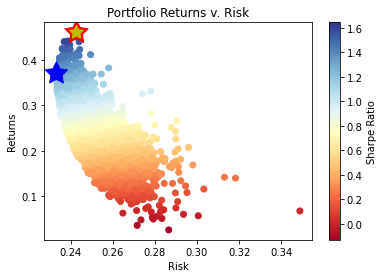

In [92]:
plt.scatter(y = simulations_df['Returns'], x = simulations_df['Volatility'], c = simulations_df['Sharpe Ratio'], cmap = 'RdYlBu')
plt.title('Portfolio Returns v. Risk')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Risk')
plt.ylabel('Returns')

print('Maximum Sharpe Ratio: Red; Maximum Returns: Yellow; Minimum Volatility: Blue')
plt.scatter(max_sharpe_ratio[1], max_sharpe_ratio[0], marker = (5, 1, 0), color = 'r', s = 600)
plt.scatter(max_returns[1], max_returns[0], marker = (5, 1, 0), color = 'y', s = 200)
plt.scatter(min_volatility[1], min_volatility[0], marker = (5, 1, 0), color = 'b', s = 550)

In [93]:
# Optimization
# the monte carlo simulation is not the most efficient way to find optimal values; we can use mathematical techniques to arrive at these values instead
# source: https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb

In [94]:
# defining functions to:
# 1. find the sharpe ratio, returns, and volatility given portfolio weights
# 2. obtain the minimum sharpe ratio (since scipy's optimization does not have a maximize function; we obtain the maximum sharpe ratio by multiplying the sharpe ratio by -1 and finding the minimum value), minimum returns (same logic as the sharpe ratio), and minimum volatility
# 3. check if the sum of weights equals 1 

def get_metrics(weights:list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """
    weights = np.array(weights)
    returns = np.sum(log_returns.mean()*weights)*252
    volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))
    sharpe_ratio = (returns - 0.0625)/volatility
    return np.array([returns, volatility, sharpe_ratio])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return -get_metrics(weights)[2]

def grab_negative_returns(weights: list) -> np.array:
    """The function used to minimize the returns.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return -get_metrics(weights)[0]


def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the volatility.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1
    

In [95]:
# optimizing the sharpe ratio

bounds = tuple((0, 1) for symbol in range(number_of_symbols)) # to ensure we don't invest more than 100% of our funds
constraints = ({'type': 'eq', 'fun': check_sum})

initial_weights = number_of_symbols * [1./number_of_symbols,]

optimized_sharpe = sciop.minimize(grab_negative_sharpe, initial_weights, method = 'SLSQP', bounds = bounds, constraints = constraints)
optimized_metrics = get_metrics(weights = optimized_sharpe.x)

print('OPTIMIZED SHARPE RATIO')
print('OPTIMIZED WEIGHTS (AAPL, MSFT, GOOG, AMZN, NFLX)')
print(optimized_sharpe.x)
print('OPTIMIZED METRICS (returns, volatility, sharpe ratio)')
print(optimized_metrics)


OPTIMIZED SHARPE RATIO
OPTIMIZED WEIGHTS (AAPL, MSFT, GOOG, AMZN, NFLX)
[8.32667268e-17 0.00000000e+00 1.00000000e+00 4.16333634e-16
 0.00000000e+00]
OPTIMIZED METRICS (returns, volatility, sharpe ratio)
[0.56861738 0.26424624 1.91532484]


In [96]:
# optimizing the returns

bounds = tuple((0, 1) for symbol in range(number_of_symbols)) # to ensure we don't invest more than 100% of our funds
constraints = ({'type': 'eq', 'fun': check_sum})

initial_weights = number_of_symbols * [1./number_of_symbols,]

optimized_returns = sciop.minimize(grab_negative_returns, initial_weights, method = 'SLSQP', bounds = bounds, constraints = constraints)
optimized_metrics = get_metrics(weights = optimized_returns.x)

print('OPTIMIZED RETURNS')
print('OPTIMIZED WEIGHTS (AAPL, MSFT, GOOG, AMZN, NFLX)')
print(optimized_returns.x)
print('OPTIMIZED METRICS (returns, volatility, sharpe ratio)')
print(optimized_metrics)

OPTIMIZED RETURNS
OPTIMIZED WEIGHTS (AAPL, MSFT, GOOG, AMZN, NFLX)
[2.63677968e-16 5.03069808e-16 1.00000000e+00 0.00000000e+00
 4.23272528e-16]
OPTIMIZED METRICS (returns, volatility, sharpe ratio)
[0.56861738 0.26424624 1.91532484]


In [97]:
# optimizing the volatility

bounds = tuple((0, 1) for symbol in range(number_of_symbols)) # to ensure we don't invest more than 100% of our funds
constraints = ({'type': 'eq', 'fun': check_sum})

initial_weights = number_of_symbols * [1./number_of_symbols,]

optimized_volatility = sciop.minimize(grab_volatility, initial_weights, method = 'SLSQP', bounds = bounds, constraints = constraints)
optimized_metrics = get_metrics(weights = optimized_volatility.x)

print('OPTIMIZED VOLATILITY')
print('OPTIMIZED WEIGHTS (AAPL, MSFT, GOOG, AMZN, NFLX)')
print(optimized_volatility.x)
print('OPTIMIZED METRICS (returns, volatility, sharpe ratio)')
print(optimized_metrics)

OPTIMIZED VOLATILITY
OPTIMIZED WEIGHTS (AAPL, MSFT, GOOG, AMZN, NFLX)
[0.01185496 0.07825345 0.33496525 0.49385885 0.08106749]
OPTIMIZED METRICS (returns, volatility, sharpe ratio)
[0.35802355 0.23291048 1.2688289 ]
